In [1]:
from pulp import *
import matplotlib.pyplot as plt

In [2]:
### macierz odleglosci
D = [
    [16.160, 24.080, 24.320, 21.120],
    [19.000, 26.470, 27.240, 17.330],
    [25.290, 32.490, 33.420, 12.250],
    [0.000, 7.930, 8.310, 36.120],
    [3.070, 6.440, 7.560, 37.360],
    [1.220, 7.510, 8.190, 36.290],
    [2.800, 10.310, 10.950, 33.500],
    [2.870, 5.070, 5.670, 38.800],
    [3.800, 8.010, 7.410, 38.160],
    [12.350, 4.520, 4.350, 48.270],
    [11.110, 3.480, 2.970, 47.140],
    [21.990, 22.020, 24.070, 39.860],
    [8.820, 3.300, 5.360, 43.310],
    [7.930, 0.000, 2.070, 43.750],
    [9.340, 2.250, 1.110, 45.430],
    [8.310, 2.070, 0.000, 44.430],
    [7.310, 2.440, 1.110, 43.430],
    [7.550, 0.750, 1.530, 43.520],
    [11.130, 18.410, 19.260, 25.400],
    [17.490, 23.440, 24.760, 23.210],
    [11.030, 18.930, 19.280, 25.430],
    [36.120, 43.750, 44.430, 0.000]
]

### pracochlonnosc
P = [0.1609, 0.1164, 0.1026, 0.1516, 0.0939, 0.1320, 0.0687, 0.0930, 0.2116, 0.2529, 0.0868, 0.0828, 0.0975, 0.8177,
     0.4115, 0.3795, 0.0710, 0.0427, 0.1043, 0.0997, 0.1698, 0.2531]

### OBECNY PRZYDZIAL
A = [
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
]

### OBECNE LOKALIZACJE SIEDZIB
L = [4, 14, 16, 22]

In [28]:
def solve_problem(min_f1=True, min_f2=False, epsilon=None):
    problem = LpProblem("pfitzer", LpMinimize)
    
    I = len(A)
    J = len(A[0])
    
    variables = {}
    for i in range(I):
        for j in range(J):
            variables[(i, j)] = LpVariable(f'x_{i}_{j}', cat='Binary')
    
    # Każdy region musi mieć dokładnie jednego przedstawiciela
    for i in range(I):
        problem += lpSum([variables[(i, j)] for j in range(J)]) == 1
    
    # Suma pracochłonności dla regionów przydzielonych do jednego przedstawiciela powinna być w przedziale 0.9-1.1
    for j in range(J):
        problem += 0.9 <= lpSum([variables[(i, j)]*P[i] for i in range(I)])
        problem += lpSum([variables[(i, j)]*P[i] for i in range(I)]) <= 1.1
    
    # F1
    # Minimalizacja sumy odległości do regionów dla każdego z przedstawicieli 
    if min_f1:
        problem += lpSum([lpSum([variables[(i, j)]*D[i][j] for i in range(I)]) for j in range(J)])
    
    # F2
    # Minimalizacja zmian
    if min_f2:
        problem += lpSum([lpSum([variables[(i, j)]*P[i] for i in range(I) if not A[i][j]]) for j in range(J)])
    
    if epsilon is not None:
        problem += lpSum([lpSum([variables[(i, j)]*P[i] for i in range(I) if not A[i][j]]) for j in range(J)]) <= epsilon
    
    problem.solve(solver=GLPK(msg=False))
    solution = {variable.name: variable.varValue for variable in problem.variables()}
    f1_value = sum([sum([solution[f'x_{i}_{j}']*D[i][j] for i in range(I)]) for j in range(J)])
    f2_value = sum([sum([solution[f'x_{i}_{j}']*P[i] for i in range(I) if not A[i][j]]) for j in range(J)])
    return solution, f1_value, f2_value

In [70]:
f1, f2 = [], []
N = 10

_, _, min_value_f2 = solve_problem(False, True)
_, _, max_value_f2 = solve_problem(True, False)
epsilons = [min_value_f2 + i * (max_value_f2 - min_value_f2)/(N-1) for i in range(N)]

for epsilon in epsilons[::-1]:
    solution, f1_value, f2_value = solve_problem(True, False, epsilon)
    f1.append(f1_value)
    f2.append(f2_value)
    print(f"f1: {f1_value}, f2: {f2_value}")
    for i in range(I):
        print(f'{i}\t', end="")
        for j in range(J):
            s = solution[f'x_{i}_{j}']
            print(f"{s} ", end="")
        print()

f1: 162.43, f2: 1.1341
0	0 0 0 1 
1	0 0 0 1 
2	0 0 0 1 
3	1 0 0 0 
4	1 0 0 0 
5	1 0 0 0 
6	1 0 0 0 
7	1 0 0 0 
8	1 0 0 0 
9	0 0 1 0 
10	0 1 0 0 
11	1 0 0 0 
12	0 1 0 0 
13	0 1 0 0 
14	0 0 1 0 
15	0 0 1 0 
16	0 1 0 0 
17	0 0 1 0 
18	1 0 0 0 
19	0 0 0 1 
20	0 0 0 1 
21	0 0 0 1 
f1: 162.82, f2: 0.9944999999999999
0	0 0 0 1 
1	0 0 0 1 
2	0 0 0 1 
3	1 0 0 0 
4	1 0 0 0 
5	1 0 0 0 
6	1 0 0 0 
7	1 0 0 0 
8	1 0 0 0 
9	0 1 0 0 
10	0 0 1 0 
11	1 0 0 0 
12	0 0 1 0 
13	0 1 0 0 
14	0 0 1 0 
15	0 0 1 0 
16	0 0 1 0 
17	0 0 1 0 
18	1 0 0 0 
19	0 0 0 1 
20	0 0 0 1 
21	0 0 0 1 
f1: 171.68, f2: 0.4867
0	0 0 0 1 
1	0 0 0 1 
2	0 0 0 1 
3	1 0 0 0 
4	1 0 0 0 
5	1 0 0 0 
6	1 0 0 0 
7	1 0 0 0 
8	0 0 1 0 
9	0 0 1 0 
10	0 0 1 0 
11	0 1 0 0 
12	0 1 0 0 
13	0 1 0 0 
14	1 0 0 0 
15	0 0 1 0 
16	0 0 1 0 
17	0 1 0 0 
18	1 0 0 0 
19	0 0 0 1 
20	0 0 0 1 
21	0 0 0 1 
f1: 171.68, f2: 0.4867
0	0 0 0 1 
1	0 0 0 1 
2	0 0 0 1 
3	1 0 0 0 
4	1 0 0 0 
5	1 0 0 0 
6	1 0 0 0 
7	1 0 0 0 
8	0 0 1 0 
9	0 0 1 0 
10	0 0 1 0 
11	0 1 0 0 


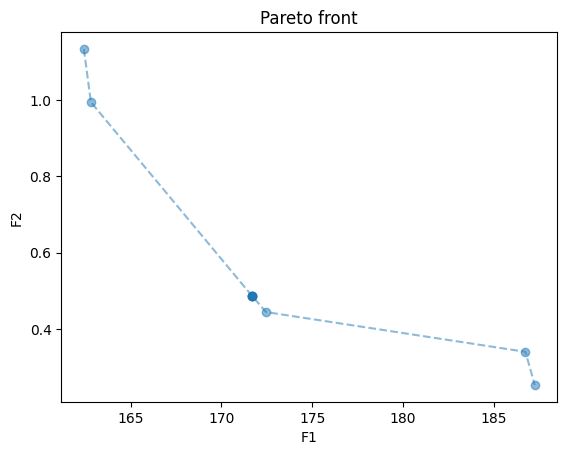

In [74]:
plt.plot(f1, f2, marker='o', linestyle='--', alpha=0.5)
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Pareto front')
plt.show();